# Correlation CPM vs. M-model Fluxes

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
from Bio import SeqIO
import re
import coralme
plt.rcParams['svg.fonttype'] = 'none'
pandas.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2

In [2]:
import cobra
gem = cobra.io.load_json_model("./pputidame/inputs/m_model.json")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-03


### Load predictions

In [3]:
fluxes = pandas.read_csv("./predictions/KT2440-MMODEL-M9.csv",index_col=0)

In [4]:
pred = pandas.Series({r.subsystem:0 for r in gem.reactions})
for r in gem.reactions:
    pred[r.subsystem] += fluxes["fluxes"].abs()[r.id]
pred.name = "predicted"

### Load omics data

In [5]:
rna = pandas.read_csv("./datasets/omics/RNA-counts.csv",sep=',',index_col=0)[["PPutida_1","PPutida_2","PPutida_4"]]

In [6]:
ribo = pandas.read_csv("./datasets/omics/RS-counts.csv",sep=',',index_col=0)[["PPutida_1","PPutida_2","PPutida_4"]]

In [7]:
samples = rna.columns.to_list()
rna_samples = [i + "_rna" for i in samples]
colors = ["#2b83ba","#66bd63","#fdae61"]

### Load Annotation

In [8]:
Annotation = pandas.read_csv("./GeneAnnotation.csv",index_col=0)

In [9]:
Annotation

,locus_tag,name,description,type,length,subsystem
PP_0001,PP_RS00005,NaN,ParB/RepB/Spo0J family partition protein,CDS,873.0,NaN
PP_0002,PP_RS00010,NaN,ParA family protein,CDS,792.0,NaN
PP_0003,PP_RS00015,rsmG,16S rRNA (guanine(527)-N(7))-methyltransferase RsmG,CDS,651.0,Translation
PP_0004,PP_RS00020,mnmG,tRNA uridine-5-carboxymethylaminomethyl(34) synthesis enzyme MnmG,CDS,1893.0,NaN
PP_0005,PP_RS00025,mnmE,tRNA uridine-5-carboxymethylaminomethyl(34) synthesis GTPase MnmE,CDS,1371.0,NaN
...,...,...,...,...,...,...
PP_5419,PP_RS28240,atpB,F0F1 ATP synthase subunit A,CDS,870.0,Metabolic:S_Oxidative_Phosphorylation
PP_5420,PP_RS28245,NaN,F0F1 ATP synthase subunit I,CDS,408.0,Metabolic:S_Oxidative_Phosphorylation
PP_0688,NaN,NaN,NaN,NaN,NaN,Translation
PP_t57,NaN,NaN,NaN,NaN,NaN,tRNA-Charging


In [10]:
pred = pred.rename({s:"Metabolic:"+s for s in pred.index if s not in Annotation["subsystem"]})

### Combine results

In [25]:
Results = ribo.join(rna,rsuffix="_rna")

In [26]:
ResultsAnnotated = pandas.concat([Results,Annotation],axis=1).loc[Results.index]
ResultsAnnotated.head()

,PPutida_1,PPutida_2,PPutida_4,PPutida_1_rna,PPutida_2_rna,PPutida_4_rna,locus_tag,name,description,type,length,subsystem
PP_0001,4404.0,4187.0,2165.0,64.0,185.0,203.0,PP_RS00005,NaN,ParB/RepB/Spo0J family partition protein,CDS,873.0,NaN
PP_0010,24817.0,27045.0,10591.0,130.0,329.0,274.0,PP_RS00050,dnaA,chromosomal replication initiator protein DnaA,CDS,1521.0,NaN
PP_0097,790.0,615.0,401.0,8.0,58.0,47.0,PP_RS00495,NaN,YheV family putative zinc ribbon protein,CDS,282.0,NaN
PP_0947,1253.0,1395.0,735.0,13.0,21.0,20.0,PP_RS04975,NaN,ZIP family metal transporter,CDS,894.0,NaN
PP_0948,539.0,585.0,541.0,7.0,16.0,16.0,PP_RS04980,NaN,HPr family phosphocarrier protein,CDS,273.0,NaN


###  Group by subsystem

In [76]:
ResultsGrouped = ResultsAnnotated.groupby("subsystem").sum()

/tmp/ipykernel_53991/4173035433.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ResultsGrouped = ResultsAnnotated.groupby("subsystem").sum()


In [77]:
ResultsGrouped = pandas.concat([ResultsGrouped,pred],axis=1)

In [78]:
ResultsGrouped["predicted"] = ResultsGrouped["predicted"] + 1

In [79]:
# ResultsGrouped = ResultsAnnotated[~ResultsAnnotated["subsystem"].str.contains("S_Transport__Outer_Membrane")].groupby("subsystem").sum()

### Performance with riboseq

In [110]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

from scipy import stats
from scipy.stats import pearsonr

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     89.91
Date:                Thu, 10 Oct 2024   Prob (F-statistic):           1.58e-18
Time:                        11:26:00   Log-Likelihood:                -276.79
No. Observations:                 264   AIC:                             557.6
Df Residuals:                     262   BIC:                             564.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3596      0.049     89.213      0.0

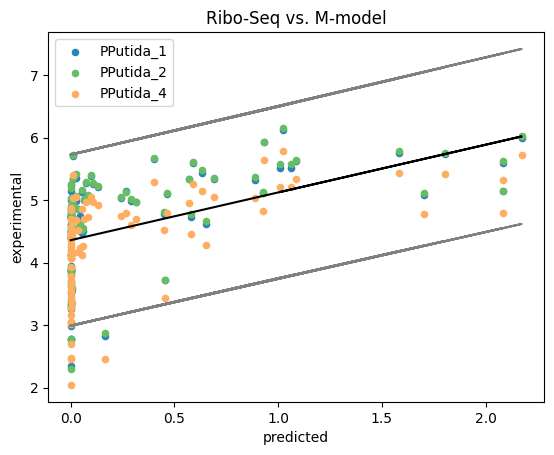

In [111]:
slist = samples
tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
# colors = ["brown","blue","green"]
X = pandas.concat([tmp[["predicted"]],tmp[["predicted"]],tmp[["predicted"]]],axis=1).stack().values
y = tmp[slist].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
fig,ax = plt.subplots(1,1)
for idx,s in enumerate(slist):
    tmp.plot.scatter("predicted",s,ax=ax,color=colors[idx],label=s)
plt.plot(X,est2.predict(),color="black")
plt.ylabel("experimental")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))

# Confidence interval
st, data, ss2 = summary_table(est2, alpha=0.05)
fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T
plt.plot(X, predict_ci_low, color="gray")
plt.plot(X, predict_ci_upp, color="gray")
plt.title("Ribo-Seq vs. M-model")

plt.savefig("./figures/riboseq-counts-bysubsystem-performance-m.svg",format="svg")

In [112]:
ypred = est2.predict()
yerr = y-ypred
errors = pandas.Series({i:j for i,j in zip(tmp[slist].mean(axis=1).index,yerr)})
errors.to_csv("datasets/omics/riboseq-mmodel-errors.csv")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     91.32
Date:                Thu, 10 Oct 2024   Prob (F-statistic):           9.32e-19
Time:                        11:26:00   Log-Likelihood:                -235.06
No. Observations:                 264   AIC:                             474.1
Df Residuals:                     262   BIC:                             481.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6485      0.042     63.478      0.0

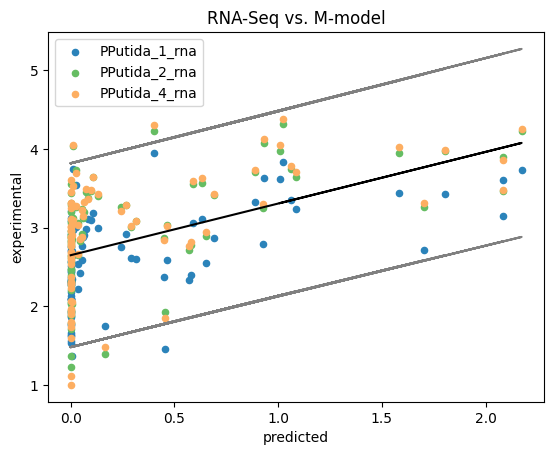

In [113]:
slist = rna_samples
tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
X = pandas.concat([tmp[["predicted"]],tmp[["predicted"]],tmp[["predicted"]]],axis=1).stack().values
y = tmp[slist].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
fig,ax = plt.subplots(1,1)
for idx,s in enumerate(slist):
    tmp.plot.scatter("predicted",s,ax=ax,color=colors[idx],label=s)
plt.plot(X,est2.predict(),color="black")
plt.ylabel("experimental")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))

# Confidence interval
st, data, ss2 = summary_table(est2, alpha=0.05)
fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T
plt.plot(X, predict_ci_low, color="gray")
plt.plot(X, predict_ci_upp, color="gray")
plt.title("RNA-Seq vs. M-model")

plt.savefig("./figures/rnaseq-counts-bysubsystem-performance-m.svg",format="svg")

In [114]:
ypred = est2.predict()
yerr = y-ypred
errors = pandas.Series({i:j for i,j in zip(tmp[slist].mean(axis=1).index,yerr)})
errors.to_csv("datasets/omics/rnaseq-mmodel-errors.csv")